# LDSC: Longitudinal PFT vs Cross-Sectional PFT + COPD

**Author**: Jesse Marks <br>
**GitHub Issue:** [#126](https://github.com/RTIInternational/bioinformatics/issues/126) <br>
**Results Uploaded:** `\\RTPNFIL02\dhancock\LungFunction\R01_GxOmega3_Decline\Analyses\Aim1GWAS\LDSC\`

This Jupyter Notebook documents the steps taken to perform LD Score Regression (LDSC)—a tool for estimating heritability and genetic correlation—on Longitudinal Pulminary Function Test (PFT) GWAS results compared to cross-sectional PFT GWAS results from LDHub and also the COPD GWAS results.

We have in-house two sets of longitudinal PFT meta-analysis GWAS results from the paper [Large-Scale Genome-Wide Association Studies and Meta-Analyses of Longitudinal Change in Adult Lung Function](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0100776):
   * longitudinal PFT All
   * longitudinal PFT Sub

The longitudinal PFT all study comprises 14 cohort studies  with the majority of the cohorts measuring FEV1 at two times per participant, but five studies (BHS, CARDIA, CHS, FHS, Health ABC) had ≥3 FEV1 measurements per participant. The meta-analyis with all 14 cohort studies we call Longitudinal PFT All. The meta-analyis with the five studes having ≥3 FEV1 measurements per participant we call Longitudinal PFT Sub.

We perform two LDSC analyses: 
   * 001 L. PFT All as reference compared to COPD, FEV1, FVC, and FEV1/FVC
   * 002 L. PFT Sub as reference compared to COPD, FEV1, FVC, and FEV1/FVC 

We are going to utilize the [LD score regression pipeline](https://github.com/RTIInternational/ld-regression-pipeline) that Alex Waldrop developed to perform LD score regression.

## Data 
* 2 longitudinal PFTs
* COPD
* 3 cross-sectional PFTs (LDHub)

### Two Longitudinal PFTs
These data were supplied to us by Patricia A. Cassano. They are from [the published paper a GWAS of PFT](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0100776#s5). Note that we will have to split these data up by chromosome since they will be the reference traits from these analyses. Note that the coded allele for these data is allele1. See table three of the publication for reference.

`s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/PFT_longitudinal/pft_longitudinal_build37_all.tsv.gz` <br>
`s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/PFT_longitudinal/pft_longitudinal_build37_sub.tsv.gz` 

### COPD
* N=51772
* The inhouse COPD data. `s3://rti-nd/LDSC/data/COPDGWAS_HobbsEtAl/modGcNoOtherMinMissSorted.withchrpos.txt.gz`

### Three Cross-Sectional PFTs
LDHub Lung Function Studies. Note that there are new lung function results on LDHub, however they have not provided a PMID for all of the studies, therefore we cannot distinguish which data are the newest.
* Forced expiratory volume in 1 second (FEV1)
* Forced Vital capacity(FVC)
* Forced expiratory volume in 1 second (FEV1)/Forced Vital capacity(FVC)

<br><br>

___
## Workflow Guide

**Workflow guideline:**
1. Create Excel phenotype file locally then upload to EC2 instance
2. Clone https://github.com/RTIInternational/ld-regression-pipeline
3. Then edit full_ld_regression_wf_template.json to include the reference data of choice
4. Use dockerized tool to finish filling out the json file that will be input for workflow
5. Perform LDSC using the WDL workflow
   - If necessary, get results from LDHub
   - Merge data Create final plots with dockerized tool 
 
<br><br>

Here is an example entry in the Excel Phenotype File:

**trait	plot_label	sumstats_path	pmid	category	sample_size	id_col	chr_col	pos_col	effect_allele_col	ref_allele_col	effect_col	pvalue_col	sample_size_col	effect_type	w_ld_chr**
```
COPDGWAS Hobbs et al.	COPD	s3://rti-nd/LDSC/COPDGWAS_HobbsEtAl/modGcNoOtherMinMissSorted.withchrpos.txt.gz	28166215	Respiratory	51772	3	1	2	4	5	10	12		beta	s3://clustername--files/eur_w_ld_chr.tar.bz2
```

## Data Wrangling
We need to split the long. PFT data up by chromosome. <br>
Note that the long. PFT data were updated from genome build 36 to 37 when we received them.

In [ ]:
# All
cd /shared/jmarks/lung_function/ldsc/pft_decline_and_copd/001/processing
aws s3 cp s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/PFT_longitudinal/pft_longitudinal_build37_all.tsv.gz .
    
for chr in {1..22}; do
    zcat pft_longitudinal_build37_all.tsv.gz | head -1 | \
        cut -f1,2,3,4,5,10,12 > chr${chr}_pft_longitudinal_build37_all.tsv
    awk -v chrom=$chr 'BEGIN{OFS="\t"} $2==chrom {print $1,$2,$3,$4,$5,$10,$12}' \
        <(zcat pft_longitudinal_build37_all.tsv.gz |tail -n +2) >> \
        chr${chr}_pft_longitudinal_build37_all.tsv
done &

gzip *tsv
for chr in {1..22}; do 
    aws s3 cp chr${chr}_pft_longitudinal_build37_all.tsv.gz \
        s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/PFT_longitudinal/all_chromosomes/
done

# Sub
cd /shared/jmarks/lung_function/ldsc/pft_decline_and_copd/002/processing
aws s3 cp s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/PFT_longitudinal/pft_longitudinal_build37_sub.tsv.gz .
    
for chr in {1..22}; do
    zcat pft_longitudinal_build37_sub.tsv.gz | head -1 | \
        cut -f1,2,3,4,5,10,12 > chr${chr}_pft_longitudinal_build37_sub.tsv
    awk -v chrom=$chr 'BEGIN{OFS="\t"} $2==chrom {print $1,$2,$3,$4,$5,$10,$12}' \
        <(zcat pft_longitudinal_build37_sub.tsv.gz |tail -n +2) >> \
        chr${chr}_pft_longitudinal_build37_sub.tsv
done &

gzip *tsv
for chr in {1..22}; do 
    aws s3 cp chr${chr}_pft_longitudinal_build37_sub.tsv.gz \
        s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/PFT_longitudinal/sub_chromosomes/
done

# 001
`fefa8914-de27-4c61-ab12-263974ab64cf`

In [ ]:
### local ###

## edit phenotype file and upload to EC2 instance
cd ~/Projects/lungfunction/ldsc/pft_decline_and_copd/001/processing/input/cromwell
scp -i ~/.ssh/gwas_rsa *xlsx ec2-user@34.195.174.206:/shared/jmarks/lung_function/ldsc/pft_decline_and_copd/001/

In [ ]:
### EC2 ###
## 1. upload Excel phenotype file to EC2 instance
## 2. then edit full_ld_regression_wf_template.json to include the reference data of choice
## 3. lastly use dockerized tool to finish filling out the json file that will be input for workflow

## login to a larger compute node
screen
qrsh

# clone github repo
phenD=20200113_lung_function_ldsc_phenotypes_local.xlsx # from local
procD=/shared/jmarks/lung_function/ldsc/pft_decline_and_copd/001
cd $procD
git clone https://github.com/RTIInternational/ld-regression-pipeline
    
# edit file-input json
cd ld-regression-pipeline
mkdir workflow_inputs
cp json_input/full_ld_regression_wf_template.json workflow_inputs # edit this file
cd workflow_inputs
mv $procD/$phenD .
## vim edit full*json file (see README.md at https://github.com/RTIInternational/ld-regression-pipeline)

docker run -v $procD/ld-regression-pipeline/workflow_inputs/:/data/ \
    rticode/generate_ld_regression_input_json:1ddbd682cb1e44dab6d11ee571add34bd1d06e21 \
    --json-input /data/full_ld_regression_wf_template.json \
    --pheno-file /data/$phenD >\
        $procD/ld-regression-pipeline/workflow_inputs/final_wf_inputs.json

In [ ]:
## zip appropriate files 
# Change to directory immediately above metaxcan-pipeline repo
cd $procD/ld-regression-pipeline
cd ..
# Make zipped copy of repo somewhere
zip --exclude=*var/* --exclude=*.git/* -r \
    $procD/ld-regression-pipeline/workflow_inputs/ld-regression-pipeline.zip \
    ld-regression-pipeline

## copy cromwell config file from S3 to EC2 instance
cd /shared/jmarks/bin/cromwell
#aws s3 cp s3://rti-cromwell-output/cromwell-config/cromwell_default_genomics_queue.conf .

## Run workflow—Navigate to cromwell directory
java -Dconfig.file=/shared/jmarks/bin/cromwell/cromwell_default_genomics_queue.conf \
    -jar cromwell-44.jar \
    run $procD/ld-regression-pipeline/workflow/full_ld_regression_wf.wdl \
    -i $procD/ld-regression-pipeline/workflow_inputs/final_wf_inputs.json \
    -p $procD/ld-regression-pipeline/workflow_inputs/ld-regression-pipeline.zip


# 002
`26cf85cd-c072-44f7-b428-150e13779b4f`

In [ ]:
### local ###

## edit phenotype file and upload to EC2 instance
cd ~/Projects/lungfunction/ldsc/pft_decline_and_copd/002/processing/input/cromwell
scp -i ~/.ssh/gwas_rsa *xlsx ec2-user@34.195.174.206:/shared/jmarks/lung_function/ldsc/pft_decline_and_copd/002/

In [ ]:
### EC2 ###
## 1. upload Excel phenotype file to EC2 instance
## 2. then edit full_ld_regression_wf_template.json to include the reference data of choice
## 3. lastly use dockerized tool to finish filling out the json file that will be input for workflow

## login to a larger compute node
screen
qrsh


# clone github repo
phenD=20200113_lung_function_ldsc_phenotypes_local.xlsx # from local
procD=/shared/jmarks/lung_function/ldsc/pft_decline_and_copd/002
cd $procD
git clone https://github.com/RTIInternational/ld-regression-pipeline
    
# edit file-input json
cd ld-regression-pipeline
mkdir workflow_inputs
cp json_input/full_ld_regression_wf_template.json workflow_inputs # edit this file
cd workflow_inputs
mv $procD/$phenD .
## vim edit full*json file (see README.md at https://github.com/RTIInternational/ld-regression-pipeline)

docker run -v $procD/ld-regression-pipeline/workflow_inputs/:/data/ \
    rticode/generate_ld_regression_input_json:1ddbd682cb1e44dab6d11ee571add34bd1d06e21 \
    --json-input /data/full_ld_regression_wf_template.json \
    --pheno-file /data/$phenD >\
        $procD/ld-regression-pipeline/workflow_inputs/final_wf_inputs.json

In [ ]:
## zip appropriate files 
# Change to directory immediately above metaxcan-pipeline repo
cd $procD/ld-regression-pipeline
cd ..
# Make zipped copy of repo somewhere
zip --exclude=*var/* --exclude=*.git/* -r \
    $procD/ld-regression-pipeline/workflow_inputs/ld-regression-pipeline.zip \
    ld-regression-pipeline

## copy cromwell config file from S3 to EC2 instance
cd /shared/jmarks/bin/cromwell
#aws s3 cp s3://rti-cromwell-output/cromwell-config/cromwell_default_genomics_queue.conf .

## Run workflow—Navigate to cromwell directory
java -Dconfig.file=/shared/jmarks/bin/cromwell/cromwell_default_genomics_queue.conf \
    -jar cromwell-44.jar \
    run $procD/ld-regression-pipeline/workflow/full_ld_regression_wf.wdl \
    -i $procD/ld-regression-pipeline/workflow_inputs/final_wf_inputs.json \
    -p $procD/ld-regression-pipeline/workflow_inputs/ld-regression-pipeline.zip


# [LD Hub](http://ldsc.broadinstitute.org/ldhub/)
```
Important notes for your uploaded file:

1. To save the uploading time, LD Hub only accepts zipped files as input (e.g. mydata.zip).

2. Please check that there is ONLY ONE plain TXT file (e.g. mydata.txt) in your zipped file.

3. Please make sure you do NOT zip any folder together with the plain txt file (e.g. /myfolder/mydata.txt), otherwise you will get an error: [Errno 2] No such file or directory

4. Please do NOT zip multiple files (e.g. zip mydata.zip file1.txt file2.txt ..) or zip a file with in a folder (e.g. zip mydata.zip /path/to/my/file/mydata.txt).

5. Please keep the file name of your plain txt file short (less than 50 characters), otherwise you may get an error: [Errno 2] No such file or directory

6. Please zip your plain txt file using following command (ONE file at a time):

For Windows system: 1) Locate the file that you want to compress. 2) Right-click the file, point to Send to, and then click Compressed (zipped) folder.

For Linux and Mac OS system: zip mydata.zip mydata.txt

Reminder: for Mac OS system, please do NOT zip you file by right click mouse and click "Compress" to zip your file, this will automatically create a folder called "__MACOS". You will get an error: [Errno 2] No such file or directory.

Upload the trait of interest
To save your upload time, we highly recommend you to use the SNP list we used in LD Hub to reduce the number of SNPs in your uploaded file. Click here to download our SNP list (w_hm3.noMHC.snplist.zip).

Please upload the zipped file you just created. Click here to download an input example.
```



## create input file 

The input file is created during the WDL workflow we ran above. LDHub requires the input data to be in a certain format, so there will be some minimal processing to do before we upload the reference phenotype file.

**Note**: Here we have switched the A1 and A2 around because LDHub expects A1 to be the effect allele. Our results have A2 as the effect allele.

In [ ]:
## PFT ALL
outF=lung_function_pft_all_ldhub_ready.txt # name of file to create for ldhub
samp_size=27249
#determine this after downloading from s3
file_name() { echo chr$1_pft_longitudinal_build37_all.tsv.standardized.phase3ID.munge_ready.txt ; }

### Download outputs for each ref chr from rftm_sumstats step ###
cd /shared/jmarks/lung_function/ldsc/pft_decline_and_copd/001/processing
aws s3 sync s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/fefa8914-de27-4c61-ab12-263974ab64cf/call-munge_ref/MUNGE_REF_WF.munge_sumstats_wf/ab75cc12-6f15-418f-ae9a-7cdab26a5345/call-munge_chr_wf/ . --quiet 
    
        
mv  */MUNGE_CHR.munge_sumstats_chr_wf/*/call-rfmt_sumstats/*standardized.phase3ID.munge_ready.txt .
rm -rf shard*

## Concat into single file ##
cat $(file_name 1) > $outF
for chr in {2..22}; do
    tail -n +2  $(file_name $chr) >> $outF
done

## Remove unnecessary columns (need snpID, A1, A2 Beta, Pvalue) in that order ##
head -1 $outF | cut -f1,4,5,6,7 > tmp
tail -n +2 $outF | awk 'BEGIN{OFS="\t"}{print $1, $4, $5, $6, $7}'  >> tmp && mv tmp $outF


## Add sample size column (sample = ) and change header names ##
cat $outF | awk -v var=$samp_size -F "\t"  \
    'BEGIN{OFS="\t";} NR==1{print "snpid", "A1", "A2", "BETA", "N", "P-value"} \
    NR>1{print $1,$2,$3,$4,var, $5}' > tmp && mv tmp $outF

zip $outF.zip $outF


###############################################################################################################################################################
## PFT Sub


outF=lung_function_pft_sub_ldhub_ready.txt # name of file to create for ldhub
samp_size=10476
#determine this after downloading from s3
file_name() { echo chr$1_pft_longitudinal_build37_sub.tsv.standardized.phase3ID.munge_ready.txt ; }

### Download outputs for each ref chr from rftm_sumstats step ###
cd /shared/jmarks/lung_function/ldsc/pft_decline_and_copd/002/processing
aws s3 sync s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/26cf85cd-c072-44f7-b428-150e13779b4f/call-munge_ref/MUNGE_REF_WF.munge_sumstats_wf/66924301-f6ab-4794-a8a8-7097bbfea60e/call-munge_chr_wf/ . --quiet 
    
mv  */MUNGE_CHR.munge_sumstats_chr_wf/*/call-rfmt_sumstats/*standardized.phase3ID.munge_ready.txt .
rm -rf shard*

## Concat into single file ##
cat $(file_name 1) > $outF
for chr in {2..22}; do
    tail -n +2  $(file_name $chr) >> $outF
done

## Remove unnecessary columns (need snpID, A1, A2 Beta, Pvalue) in that order ##
head -1 $outF | cut -f1,4,5,6,7 > tmp
tail -n +2 $outF | awk 'BEGIN{OFS="\t"}{print $1, $4, $5, $6, $7}'  >> tmp && mv tmp $outF


## Add sample size column (sample = ) and change header names ##
cat $outF | awk -v var=$samp_size -F "\t"  \
    'BEGIN{OFS="\t";} NR==1{print "snpid", "A1", "A2", "BETA", "N", "P-value"} \
    NR>1{print $1,$2,$3,$4,var, $5}' > tmp && mv tmp $outF

zip $outF.zip $outF


In [ ]:
cd ~/Projects/lungfunction/ldsc/pft_decline_and_copd/001/processing/input/ldhub 
scp -i ~/.ssh/gwas_rsa  ec2-user@34.195.174.206:/shared/jmarks/lung_function/ldsc/pft_decline_and_copd/001/processing/*zip .    

## upload input file
Follow the steps above to zip and upload input file. Essentially, 
* download the file created in the cell above to your local machine.
* Then zip this file (and only this file).
* Login to [LDHub](http://ldsc.broadinstitute.org/ldhub/) by clicking on `Get Started with LDHub` and then sign in with your Google email account.
* Click `Go Test Center`
* Click `Continue`
* Upload zipped file by clicking `Choose File`, naming your trait, and clicking `Continue`.
* Select traits of interest from LDHub by checking the box next to the trait of interest and then clicking `Submit your request`

**Note**: keep browser open during LDSC analysis on LDHub.

`longitudinal_pft_all`

## download LDHub output
You should see the following message after uploading your data:
```
Analysis in progress ...
1) Please keep the browser open when uploading your file.

2) The webpage will jump to the results page automatically after the QC and H2 analysis was done.

3) The rg analysis will keep running in the backend. Each rg test may take about 20 seconds. A rg analysis of all traits may take up to five hours.
```

After this page, you will see the results page with the download ready once the anaylsis has finished.

# Create Final Plot
This is needed if there were additional phenotypes used from LDHub. If no phenotypes from LDHub were included, then the we need plot was already created during the WDL workflow. For example, you can find the plot in the following location:

`s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/cad01742-2337-4c14-9f40-7b1e9965fddf/call-plot_ld/PLOT.plot_ld_regression_wf/045969b0-44b6-404e-a280-167c9ae912be/call-plot_ld_regression_results/hiv_acq_meta022v3_vs_copd.ld_regression_results.pdf`

We need to create a CSV file with the results that we want to plot. We will need to merge the results from the cromwell WDL workflow with the LDHub results. The easiest way to do this is to create an Excel spreadsheet with three different sheets. One sheet will be the output from LDHub that we downloaded earlier, the results from the cromwell WDL workflow, and then a sheet that contains the merged results. The cromwell workflow results can be found in the `cromwell_output/call-plot_ld/` folder. For example, `s3://rti-hiv/ldsc/20190911_meta022v3_copd_lung_function/cromwell_output/call-plot_ld/PLOT.plot_ld_regression_wf/045969b0-44b6-404e-a280-167c9ae912be/call-make_plot_table/hiv_acq_meta022v3_vs_copd.ld_regression_results.tsv`. 

The merged CSV file should have the header:
```
trait2	Trait_Label	Trait_Group	rg	se	z	p	h2_obs	h2_obs_se	h2_int	h2_int_se	gcov_int	gcov_int_se
```

For an example file, see: <br>
`s3://rti-hiv/ldsc/20190911_meta022v3_copd_lung_function/final/20190911_hivacq_ldsc_meta022v3_vs_COPD_and_ldhub_lung_function_results_table.csv`

**Note**: I had to upload my results table to an EC2 instance in order to run the next cell which creates the plot of the merged results.

In [ ]:
## enter interactive mode ##

# note that the image tag corresponds to the latest tag for this image
docker run -it -v"/shared/jmarks/lung_function/ldsc/pft_decline_and_copd/001/plot:/data/" \
    rticode/plot_ld_regression_results:b018e08753390ee773ed7e9eb2ca851c88eee749  /bin/bash


Rscript /opt/plot_ld_regression/plot_ld_regression_results.R  \
    --input_file 20200114_lung_function_ldsc_pft_all_rg_results.csv \
    --output_file 20200114_lung_function_ldsc_pft_all_rg_results.pdf  \
    --comma_delimited \
    --title "Longitudinal PFT All"

## Copy results

Copy the input files, a README, and the plot we created to a corresponding S3 bucket and/or shared drive.

## View plot 

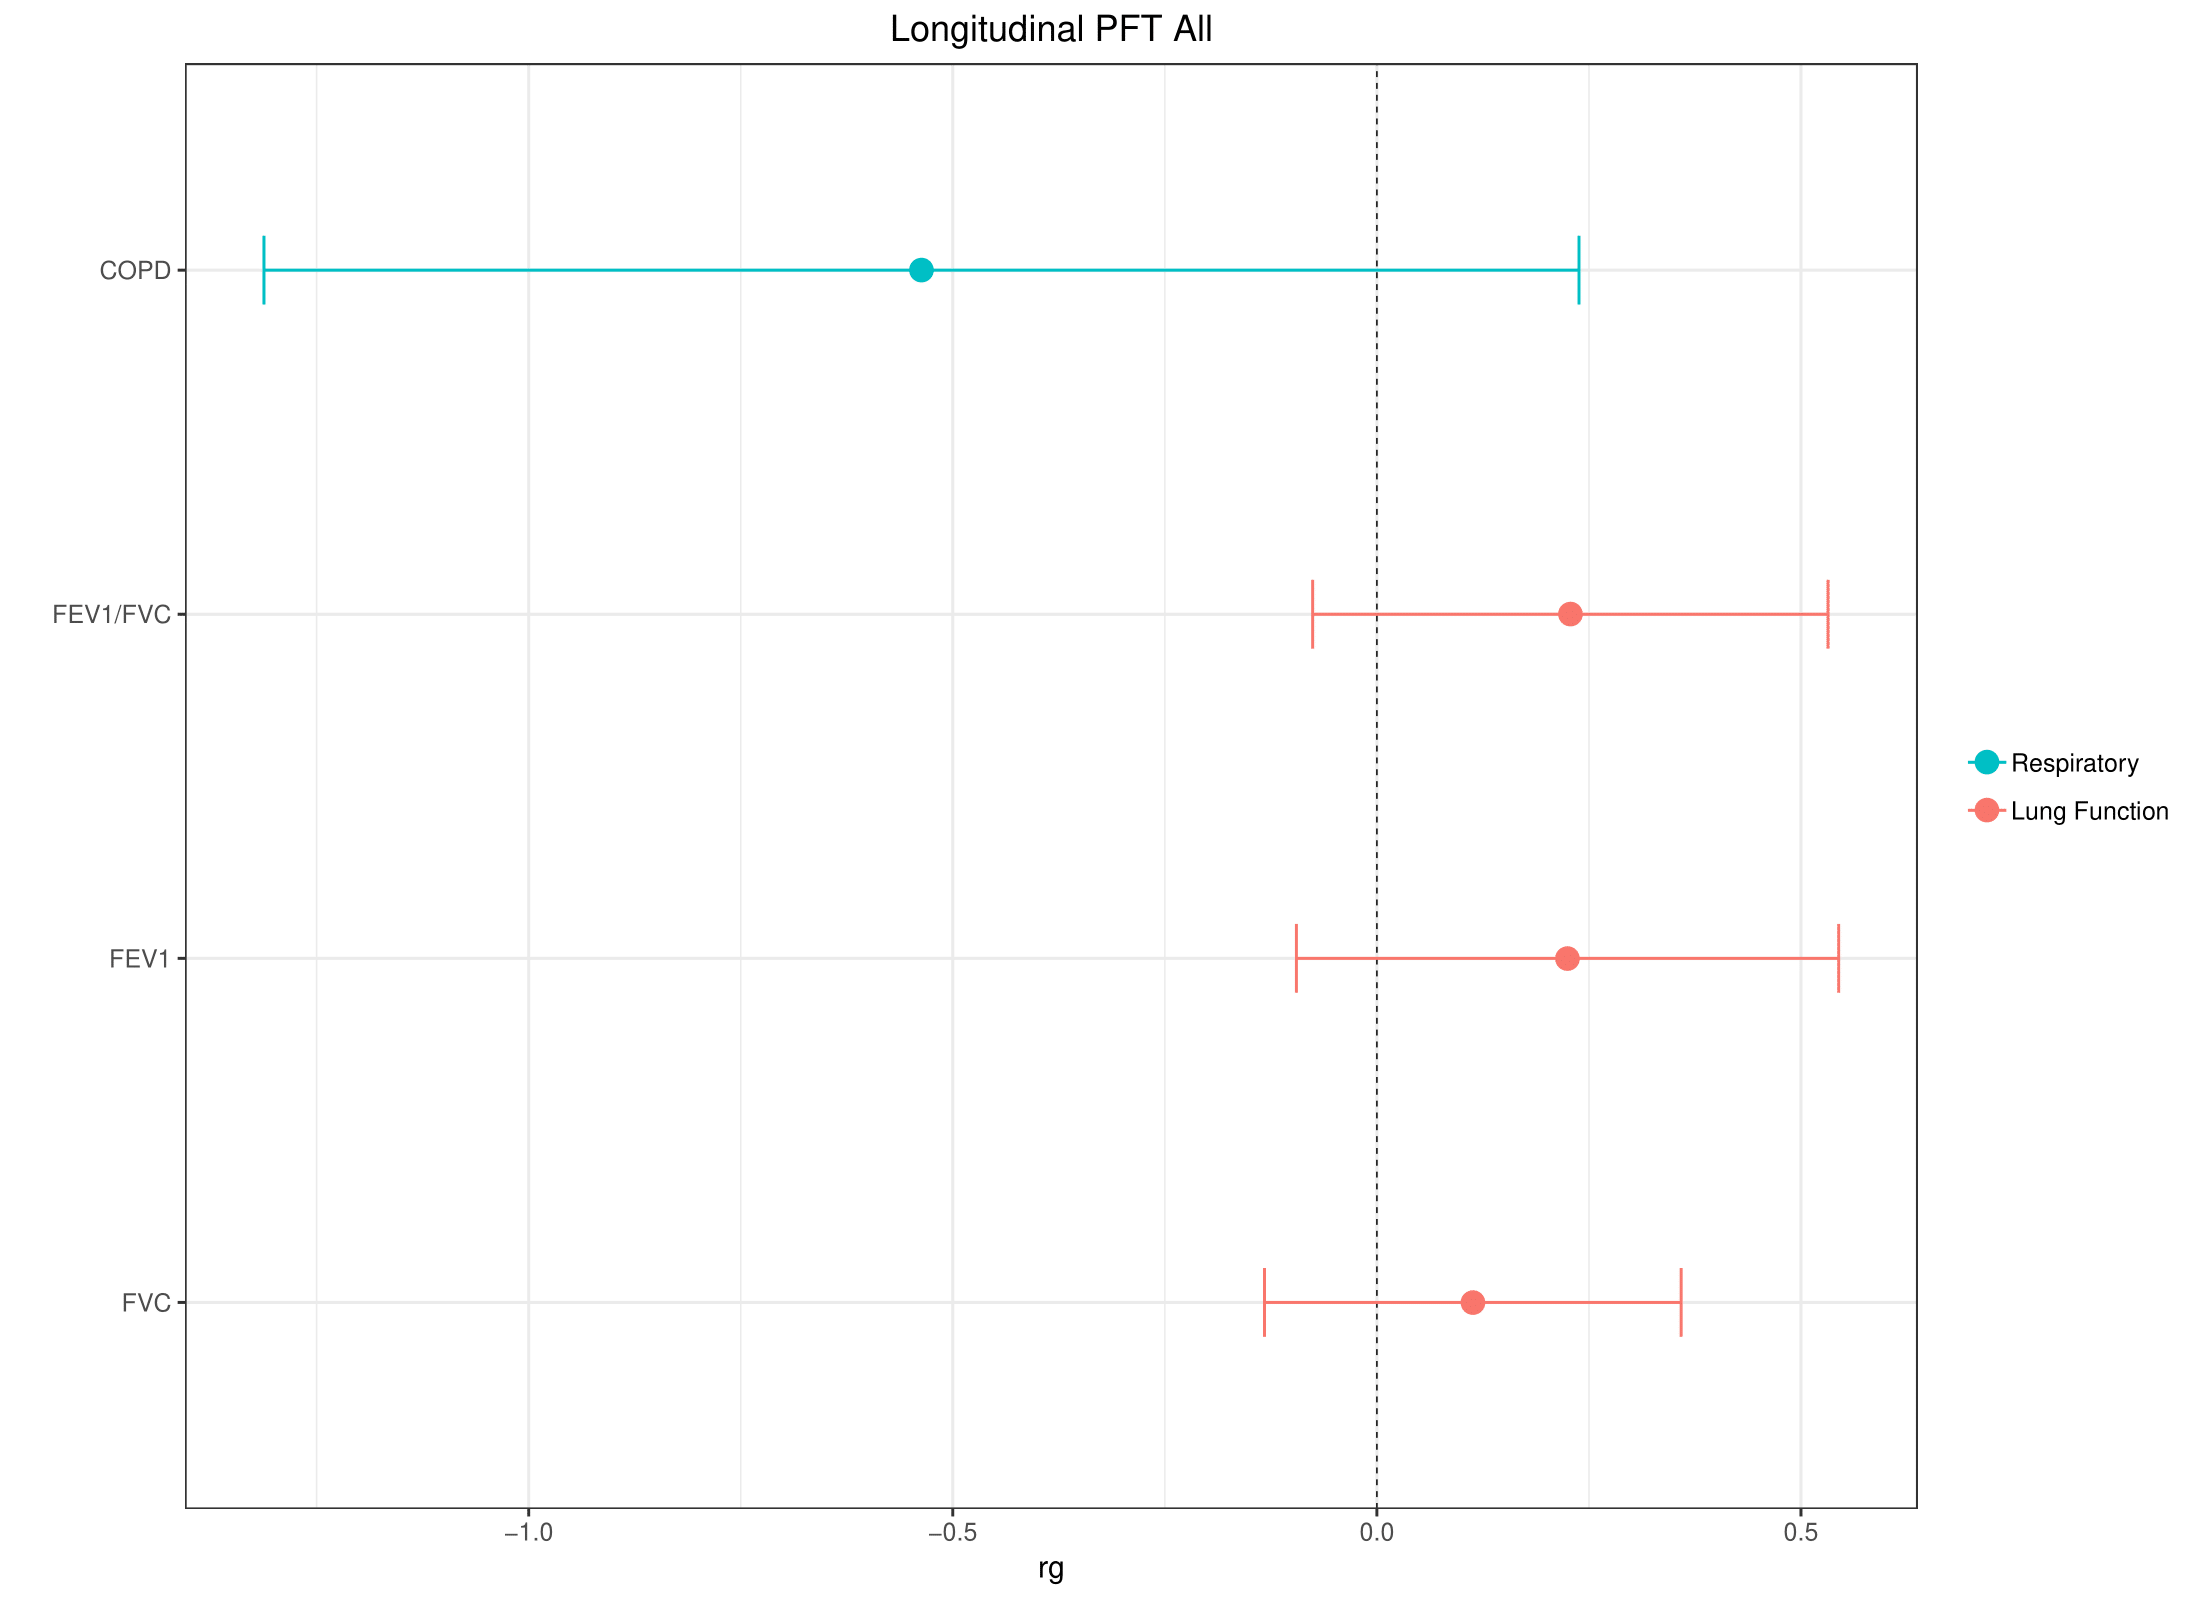

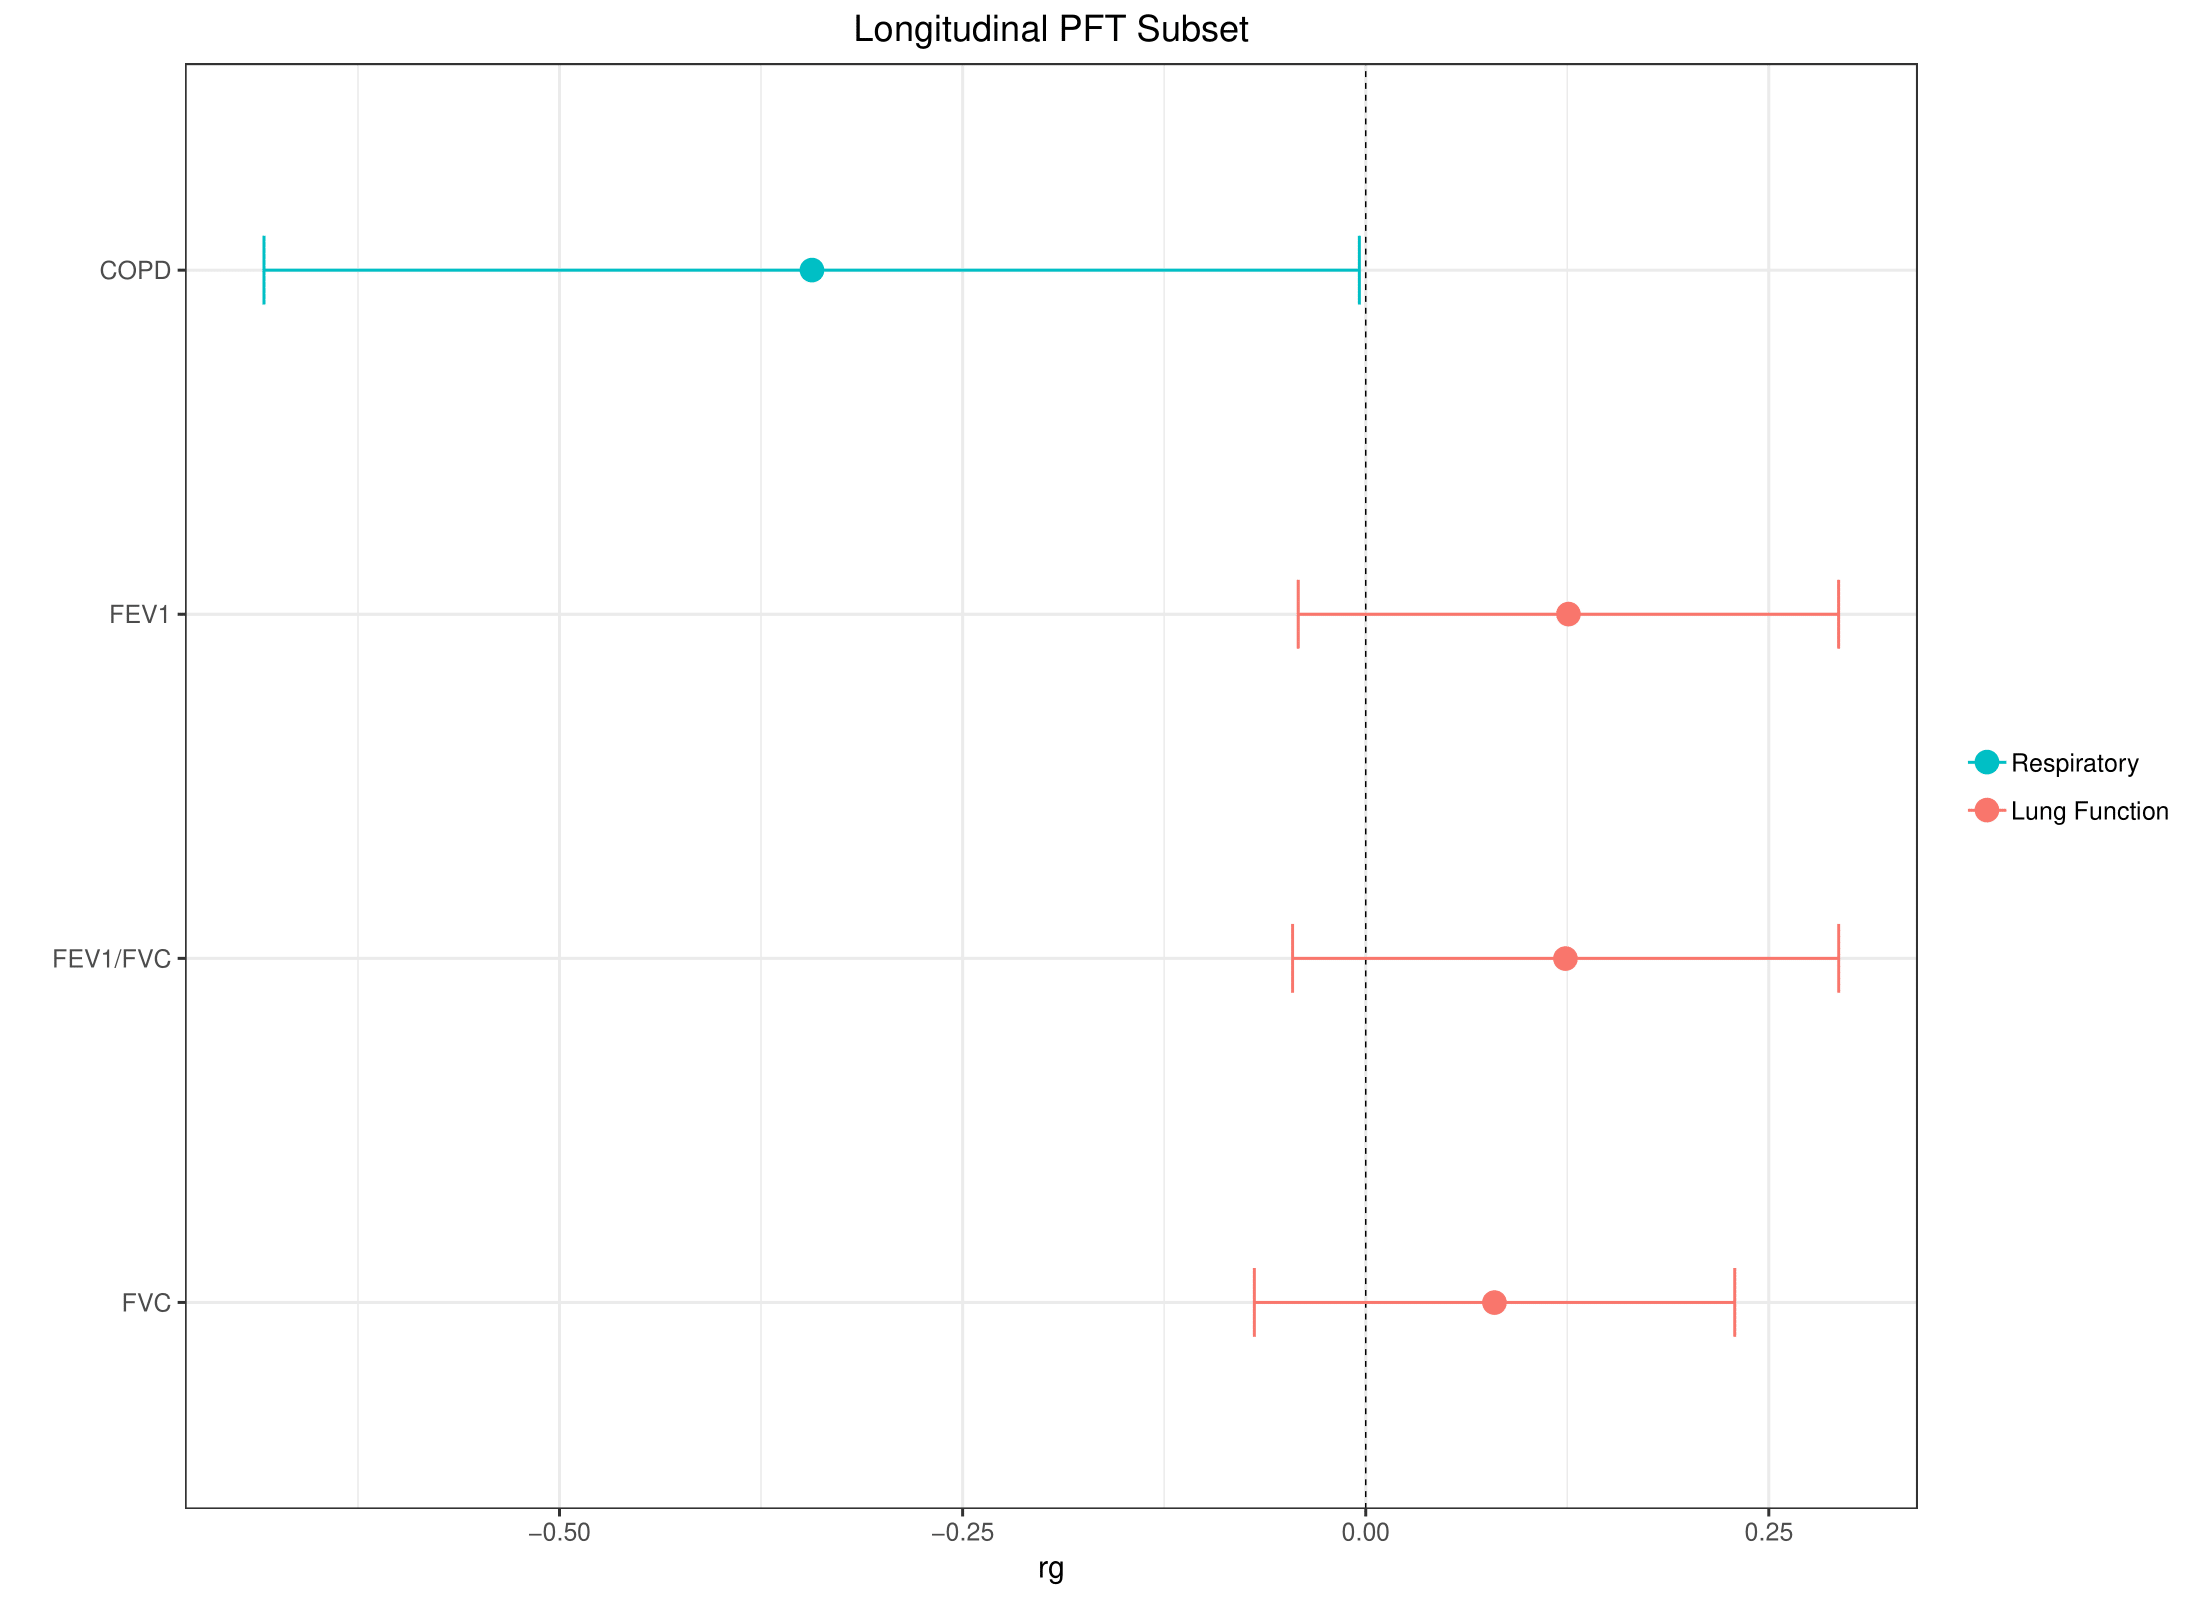

In [10]:
from IPython.display import Image
ldsc_all = Image(filename='C://Users/jmarks/OneDrive - Research Triangle Institute/Projects/lungfunction/ldsc/pft_decline_and_copd/001/final/20200114_lung_function_ldsc_pft_all_rg_results-1.png')
ldsc_sub = Image(filename='C://Users/jmarks/OneDrive - Research Triangle Institute/Projects/lungfunction/ldsc/pft_decline_and_copd/002/final/20200114_lung_function_ldsc_pft_sub_rg_results-1.png')
display(ldsc_all, ldsc_sub)